##Extendible Swap
Extendible Swap은 계약 기간을 연장할 수 있는 권리가 포함된 스왑 계약입니다. 이는 특정 조건이 만족되면 스왑의 한 당사자가 계약 기간을 연장할 수 있는 옵션을 가지는 구조입니다.

In [4]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# Google Colab에 NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 설치된 폰트 확인 및 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

<ipython-input-5-9d4ab1e88786>:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Extendible Swap의 현재 가치: 78612.58


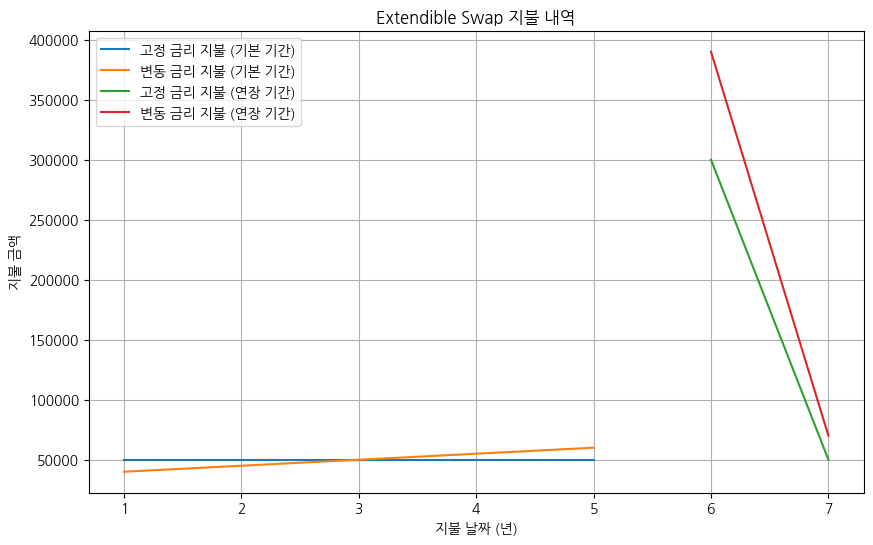

In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 블랙-숄즈 모델을 사용하여 옵션 가격을 계산하는 함수
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# 고정 금리 지불 계산 함수
def fixed_leg_payment(notional, fixed_rate, payment_dates):
    payments = notional * fixed_rate * np.diff(payment_dates, prepend=0)
    return payments

# 변동 금리 지불 계산 함수
def floating_leg_payment(notional, floating_rates, payment_dates):
    payments = notional * floating_rates * np.diff(payment_dates, prepend=0)
    return payments

# Extendible Swap의 현재 가치 계산 함수
def extendible_swap_value(notional, fixed_rate, floating_rates, swap_start, swap_end, extended_end, payment_dates, discount_factors, extend_date, extend_strike, volatility):
    """
    notional: 명목 금액
    fixed_rate: 고정 금리
    floating_rates: 변동 금리 배열
    swap_start: 스왑 시작 시점
    swap_end: 스왑 종료 시점
    extended_end: 연장된 스왑 종료 시점
    payment_dates: 지불 날짜 배열
    discount_factors: 할인율 배열
    extend_date: 연장 옵션 행사 날짜
    extend_strike: 연장 옵션 행사가격
    volatility: 변동성
    """
    # 고정 금리 지불 계산 (기본 기간)
    fixed_leg_payments_basic = fixed_leg_payment(notional, fixed_rate, payment_dates[payment_dates <= swap_end])

    # 변동 금리 지불 계산 (기본 기간)
    floating_leg_payments_basic = floating_leg_payment(notional, floating_rates[payment_dates <= swap_end], payment_dates[payment_dates <= swap_end])

    # 스왑의 현재 가치 계산 (기본 기간)
    swap_value_basic = np.sum((floating_leg_payments_basic - fixed_leg_payments_basic) * discount_factors[:len(fixed_leg_payments_basic)])

    # 고정 금리 지불 계산 (연장 기간)
    fixed_leg_payments_extended = fixed_leg_payment(notional, fixed_rate, payment_dates[payment_dates > swap_end])

    # 변동 금리 지불 계산 (연장 기간)
    floating_leg_payments_extended = floating_leg_payment(notional, floating_rates[payment_dates > swap_end], payment_dates[payment_dates > swap_end])

    # 스왑의 현재 가치 계산 (연장 기간)
    swap_value_extended = np.sum((floating_leg_payments_extended - fixed_leg_payments_extended) * discount_factors[len(fixed_leg_payments_basic):])

    # 연장 옵션의 가치 계산 (스왑을 연장할 수 있는 권리)
    time_to_extend = extend_date - swap_start
    option_value = black_scholes_call(swap_value_extended, extend_strike, time_to_extend, np.mean(discount_factors), volatility)

    return swap_value_basic + option_value

# 예시 데이터
notional = 1000000  # 명목 금액
fixed_rate = 0.05  # 고정 금리 (5%)
floating_rates = np.array([0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07])  # 변동 금리
swap_start = 0  # 스왑 시작 시점
swap_end = 5    # 스왑 종료 시점 (5년)
extended_end = 7  # 연장된 스왑 종료 시점 (7년)
payment_dates = np.array([1, 2, 3, 4, 5, 6, 7])  # 지불 날짜 (매년)
discount_factors = np.exp(-0.05 * payment_dates)  # 할인율
extend_date = 5  # 연장 옵션 행사 날짜 (5년 후)
extend_strike = 0.0  # 연장 옵션 행사가격 (스왑 가치의 행사가격)
volatility = 0.2  # 변동성

# Extendible Swap의 현재 가치 계산
extendible_swap_val = extendible_swap_value(notional, fixed_rate, floating_rates, swap_start, swap_end, extended_end, payment_dates, discount_factors, extend_date, extend_strike, volatility)
print(f"Extendible Swap의 현재 가치: {extendible_swap_val:.2f}")

# 시각화
fixed_leg_payments_basic = fixed_leg_payment(notional, fixed_rate, payment_dates[payment_dates <= swap_end])
floating_leg_payments_basic = floating_leg_payment(notional, floating_rates[payment_dates <= swap_end], payment_dates[payment_dates <= swap_end])

fixed_leg_payments_extended = fixed_leg_payment(notional, fixed_rate, payment_dates[payment_dates > swap_end])
floating_leg_payments_extended = floating_leg_payment(notional, floating_rates[payment_dates > swap_end], payment_dates[payment_dates > swap_end])

plt.figure(figsize=(10, 6))
plt.plot(payment_dates[payment_dates <= swap_end], fixed_leg_payments_basic, label='고정 금리 지불 (기본 기간)')
plt.plot(payment_dates[payment_dates <= swap_end], floating_leg_payments_basic, label='변동 금리 지불 (기본 기간)')
plt.plot(payment_dates[payment_dates > swap_end], fixed_leg_payments_extended, label='고정 금리 지불 (연장 기간)')
plt.plot(payment_dates[payment_dates > swap_end], floating_leg_payments_extended, label='변동 금리 지불 (연장 기간)')
plt.xlabel('지불 날짜 (년)')
plt.ylabel('지불 금액')
plt.title('Extendible Swap 지불 내역')
plt.legend()
plt.grid(True)
plt.show()
